Импорт плагинов

In [1]:
import folium
import pandas as pd
import geopandas as gpd

from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from folium.plugins import GroupedLayerControl

from shapely import geometry

Импорт уровней, задавание их имени

In [2]:
class geojson_load:
    def __init__(self, layer_name, layer_path):
        self.name = layer_name
        self.data = gpd.read_file(layer_path)

okn_points = geojson_load(
    layer_name = 'Точки ОКН',
    layer_path ='data/points.geojson')

okn_buildings = geojson_load(
    layer_name = 'Контур ОКН-объектов капитального строительства',
    layer_path = 'data/buildings.geojson')
okn_buildings.legend = 'Число ОКН'

hotels = geojson_load(
    layer_name = 'Теплокарта концентрации гостиниц',
    layer_path = 'data/hotels.geojson')

admin_boundary = geojson_load(
    layer_name = 'Административная граница',
    layer_path = 'data/admin_boundary.geojson')

grid_layer_name = 'Число ОКН агрегированное по сетке'




Настройки карты

In [17]:
zoom_start = 14
tiles = 'https://api.mapbox.com/styles/v1/heizern/clfjq8u76000601pdnotlz682/tiles/256/{z}/{x}/{y}@2x?access_token=pk.eyJ1IjoiaGVpemVybiIsImEiOiJja283cmh5OWcxeW8xMnhscHdlcnB2ZWp6In0.7XU4-TcOsJKNHaME3CAayg'
attr = (
    '&copy; <a href="http://www.openstreetmap.org/copyright">OpenStreetMap</a> '
    'contributors, &copy; <a href="https://www.mapbox.com/about/maps/">Mapbox</a>'
)
start_loc = [51.758, 55.104]
square_size = 300

m = folium.Map(location = start_loc, 
               zoom_start = zoom_start, tiles = None, control_scale = True )
folium.TileLayer(tiles, attr = attr, name='Подложка').add_to(m)

In [5]:
# Проверка
m

Добавление административных границ

In [6]:
folium.GeoJson(admin_boundary.data,
               name=admin_boundary.name, 
               control=False, 
               style_function=lambda x: {
        "color": 'black', 'weight': '2', 'fillOpacity' :0
    }).add_to(m)

Создание сетки и подсчет числа памятников

In [7]:
minX, minY, maxX, maxY = okn_points.data.total_bounds
grid_cells = []
x, y = (minX, minY)
geom_array = []

while y <= maxY:
        while x <= maxX:
            geom = geometry.Polygon([(x,y), (x, y+square_size), (x+square_size, y+square_size), (x+square_size, y), (x, y)])
            geom_array.append(geom)
            x += square_size
        x = minX
        y += square_size


fishnet = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs('EPSG:32640')
fishnet['id'] = fishnet.index
merged = gpd.sjoin(okn_points.data, fishnet, how='left', predicate='within')
merged['n'] = 1
merged = merged.dissolve(by="index_right", aggfunc="count")
fishnet.loc[merged.index, 'n'] = merged.n.values

Добавление сетки на карту

In [8]:
grid_layer = folium.Choropleth(
    geo_data=fishnet,
    data=fishnet,
    columns=['id', 'n'],
    fill_color='BuGn',
    fill_opacity = 0.5,
    key_on='id',
    nan_fill_opacity=0,
   line_color = "#0000",
   legend_name=okn_buildings.legend,
   name=grid_layer_name
)
grid_layer.add_to(m)

Добавление теплокарты отелей на карту

In [9]:
hotels.data = hotels.data.to_crs('EPSG:4326')
hotels.data = hotels.data.dropna()
hotels_heatmap = folium.FeatureGroup(name = hotels.name)
HeatMap(zip(hotels.data.geometry.y, hotels.data.geometry.x),
        gradient = {0.1 : '#ffffe3', 0.2 : '#fff7b9', 0.3 : '#fee490', 0.4: '#ffc24f', 0.5:'#fe9829', 0.6:'#ec7114', 0.7:'#cc4c05',0.8:'#963606',0.9:'#672502'},
        min_opacity = 0.2
        ).add_to(hotels_heatmap)
hotels_heatmap.add_to(m)

Добавление слоя зданий ОКН

In [10]:
buildings = folium.FeatureGroup(name = okn_buildings.name)
folium.GeoJson(
    okn_buildings.data,
    name=okn_buildings.name,
    style_function=lambda x: {
        "fillColor": '#1e1e1e' if x['properties']['is_ensemble'] else '#df9f84',
        'weight':0.5,
        'color':'#1e1e1e',
        'fillOpacity':0.8,
    },
    highlight_function=lambda x: {"fillOpacity": 0.5},
    zoom_on_click=True,
).add_to(buildings)
buildings.add_to(m)



Добавление точек ОКН

In [19]:
# Поскольку кластеры с tooltip и popup нельзя создать напрямую из json происходят дополнительные действия

# Создание листа с popup
temp_list = []
for column, alias in zip(['name','registry_number','address','category','type'],['Название:', 'Номер в реестре:','Адрес:', 'Уровень значения:', 'Тип ОКН:']):
    if column != 'type':
        temp_list.append(okn_points.data[column].apply(lambda x: f"""<b>{alias}</b>: {x} <br>"""))
    else:
        temp_list.append(okn_points.data[column].apply(lambda x: f"""<b>{alias}</b>: {x}"""))
popup_list = pd.concat(temp_list,axis=1).apply(lambda x: ''.join(x), axis=1).tolist()

# Создание листа с tooltip
tooltip_list = okn_points.data['name'].apply(lambda x: f""""<b>{x}<b>""").tolist()

# Создание листа с иконками
icons_list = okn_points.data[['has_svg', 'icon_path','type']].apply(lambda x: folium.CustomIcon(x['icon_path'], icon_size=[30,30]) if bool(x['has_svg']) else folium.Icon('yellow' if x['type'] == 'Ансамбль' else 'red'), axis=1).tolist()

# Создание MarkerCluster
okn_points.data = okn_points.data.to_crs("EPSG:4326")
okn_points_cluster = MarkerCluster(
    name=okn_points.name,
    locations = list(zip(okn_points.data.geometry.y, okn_points.data.geometry.x)),
    tooltips = tooltip_list,
    icons=icons_list,
    popups = popup_list
)
okn_points_cluster.add_to(m)



/var/folders/68/jw5z6r3s28v0bwjv5nqhnwm40000gn/T/ipykernel_43776/3768580592.py:16: UserWarning: color argument of Icon should be one of: {'darkred', 'lightblue', 'orange', 'darkpurple', 'purple', 'beige', 'black', 'pink', 'red', 'white', 'darkblue', 'blue', 'lightgreen', 'lightgray', 'lightred', 'gray', 'green', 'darkgreen', 'cadetblue'}.
  icons_list = okn_points.data[['has_svg', 'icon_path','type']].apply(lambda x: folium.CustomIcon(x['icon_path'], icon_size=[30,30]) if bool(x['has_svg']) else folium.Icon('yellow' if x['type'] == 'Ансамбль' else 'red'), axis=1).tolist()



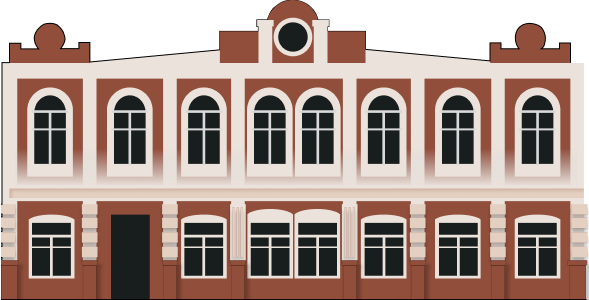
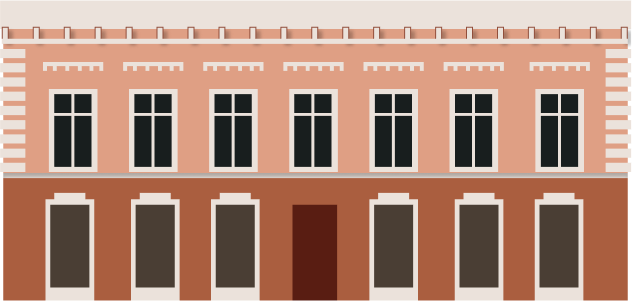
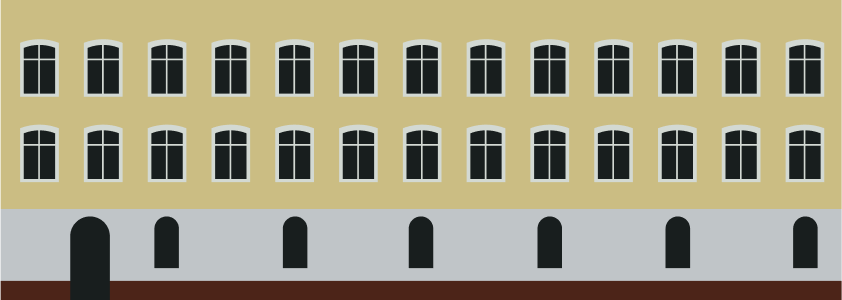
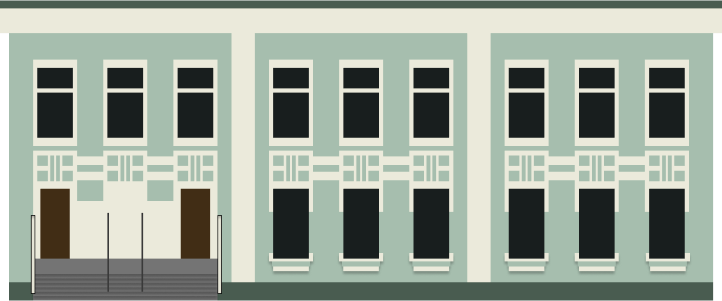
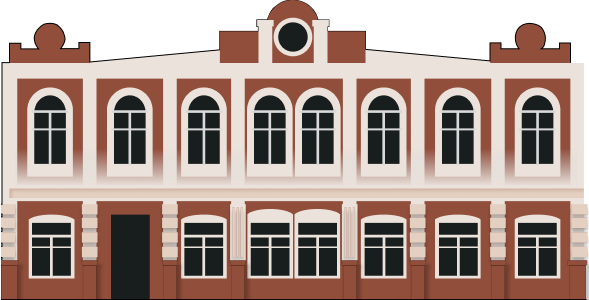
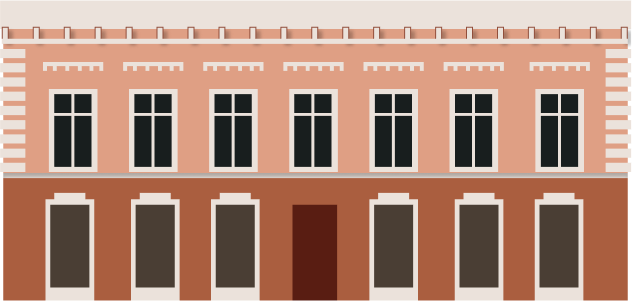
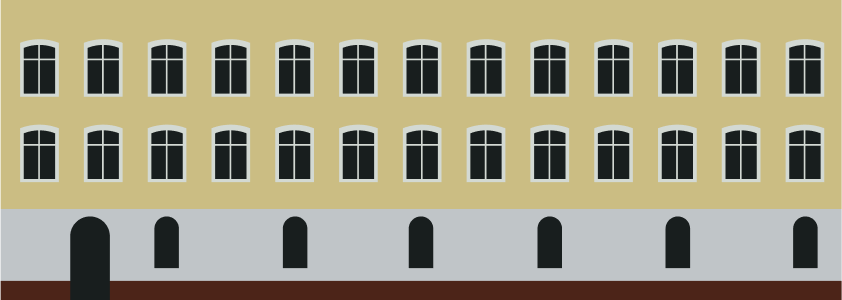
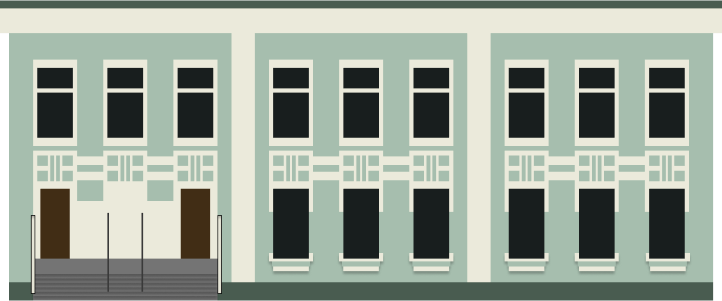

In [20]:
m

Добавление виджетов

In [13]:
from folium.plugins import MousePosition
from folium.plugins import Fullscreen

MousePosition().add_to(m)
Fullscreen(
    position="bottomright",
    title="тык",
    title_cancel="тудык",
    force_separate_button=True,
).add_to(m)

Добавление контроля уровней

In [14]:
GroupedLayerControl(
    groups = {'Аналитические слои': [grid_layer, hotels_heatmap],
              'ОКН': [buildings, okn_points_cluster]},
    exclusive_groups=False,
    collapsed=True,
).add_to(m)


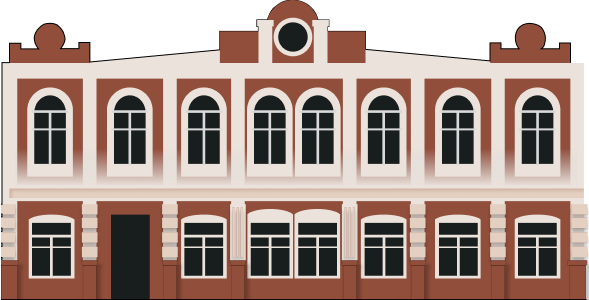
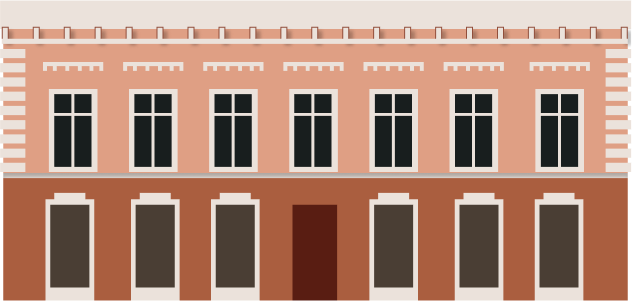
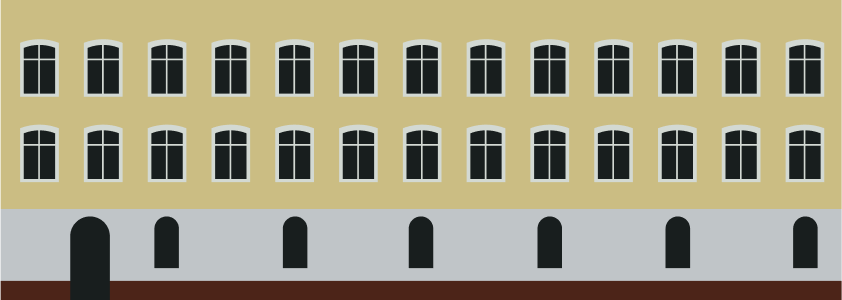
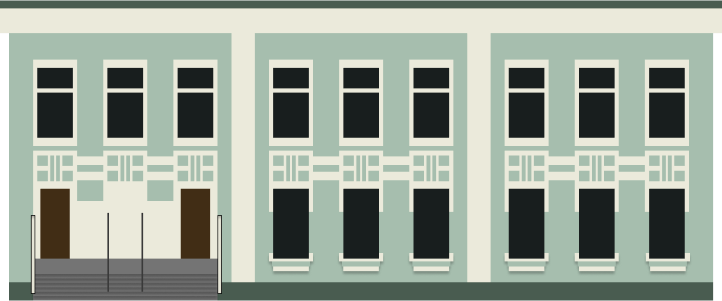

In [15]:
m

Выгрузка

In [16]:
m.save("index.html")